<div style="border: 5px solid purple; padding: 15px; margin: 5px">
<b> Reviewer's comment</b>
    
Hi Olivia, my name is Svetlana (https://hub.tripleten.com/u/6dee602c). Congratulations on submitting the second integrated project! 🎉
    

Thank you for your diligence on such a hard project!

- You have successfully added an introduction that reflects the main goal of the project, well done!  
    
    
- Read the data;

    
- Validated the data we have using the recovery calculation formula; 


- Correctly handled missing values;    
    
    
- Displayed concentration histograms for three metals and analyzed them;    
    
    
- Displayed total concentration histograms for three metals and analyzed them;  


- Compared the distributions in the test and training sets;

    
- Correctly defined the sMAPE functions; 


- Excluded columns that are not available in the test set from the training subset.    
    
    
- Trained several models; 


- Tuned hyperparameters. We tune them to identify the best model that will yield the desired metric value;


- Analyzed metrics. It is not enough to just fit the model and print the result. Instead, we have to analyze the results as it helps us identify what can be improved;

   
- Wrote an excellent conclusion! A well-written conclusion shows how the project met its objectives and provides a concise and understandable summary for those who may not have been involved in the details of the project. Good job! 


    
<font color='dodgerblue'>**To sum up:**</font> I would like to say that you demonstrated strong data science skills by successfully performing data preprocessing, handling missing values, and conducting detailed exploratory data analysis. You trained and compared machine learning models, and estimated their sMAPE scores. You did a great job, and I hope you enjoyed it.
       
    
I do not have any questions, so the project can be accepted.   


<hr>
    
✍️ Here's a nice article: [Developing Multi-Target Regression Models with Python](https://medium.com/@tubelwj/developing-multi-class-regression-models-with-python-c8beca5dd482) that you may find interesting.    


<hr>

Good luck! 

</div>

# Introduction

In this project, we are tasked with preparing a machine learning prototype for **Zyfra**, a company developing efficiency solutions for heavy industry. The business goal is to **predict the recovery of gold from ore during extraction and purification**, enabling the company to optimize production and avoid unprofitable parameters. We are provided with datasets containing measurements from different stages of the technological process (flotation, primary cleaning, and secondary cleaning), along with key features such as air volume, feed particle size, and metal concentrations.

To achieve this, we will carefully prepare the data, analyze key distributions, and build predictive models. The model’s performance will be evaluated using the **symmetric Mean Absolute Percentage Error (sMAPE)**, a metric that balances error relative to both predicted and actual values. Success will be defined by building a model that can reliably estimate recovery at both the rougher and final stages, ultimately supporting Zyfra’s production decision-making.

# Project Overview: Gold Recovery Prediction

### <u>**Goal**</u>
Build a machine-learning prototype to predict the recovery of gold at different process stages and evaluate with final **sMAPE (0.25·sMAPE(rougher) + 0.75·sMAPE(final))**.

### <u>**Data Notes:**</u>
- **Keep the date/time** column so the natural order of the process is preserved.
- **Avoid data leakage** by only training on features that also appear in the test set.
- **Do not use target columns** (the values we’re trying to predict).
- **Skip calculated outputs** that wouldn’t realistically be available when making predictions.
- **Clean the data** by filling in missing values and removing training rows where the total metal concentration is zero (which is physically impossible).

### <u>**Deliverables:**</u>
- **Data verification**: confirm recovery formula correctness and align features with the test set.
- **EDA**: analyze feature distributions, metal concentration changes, particle size consistency, and identify anomalies.
- **Modeling**: train two models (rougher + final), compare algorithms via cross-validation using final sMAPE.
- **Final evaluation**: retrain best models on the full training set and evaluate them on test timestamps using true targets from full_df.

# **1. Load Libraries & Download Data** 

In [1]:
# Core Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 12345
np.random.seed(RANDOM_STATE)

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

# Additional 
import warnings
warnings.filterwarnings('ignore')

# For statistical analysis
from scipy import stats

# Load datasets - set date column as DF index & convert to datetime
train_df = pd.read_csv('/datasets/gold_recovery_train.csv', index_col='date', parse_dates=True)
test_df  = pd.read_csv('/datasets/gold_recovery_test.csv',  index_col='date', parse_dates=True)
full_df  = pd.read_csv('/datasets/gold_recovery_full.csv',  index_col='date', parse_dates=True)

print("Train:", train_df.shape, " Test:", test_df.shape, " Full:", full_df.shape)
display(train_df.head(3))
display(test_df.head(3))

Train: (16860, 86)  Test: (5856, 52)  Full: (22716, 86)


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


### **Observations:**

<u>**Train set shape:** </u> (16860, 86) 
- contains 16,860 rows and 87 columns.
- It includes both input features and target values (rougher.output.recovery, final.output.recovery) that we’ll use to train and validate models.

<u>**Test set shape:** </u> (5856, 52) 
- contains 5,856 rows and 53 columns.
- It has fewer features than the training set because some calculated parameters and target values are not available. This matches expectations since the test set is for evaluating predictions.

<u>**Full set shape:** </u> (22716, 86) 
- full dataset contains all observations and features (22,716 rows, 87 columns).
- It serves as the source data for both train and test splits.

<u>**General Takeaways:** </u> 
- All datasets include a date index, which aligns rows by time of acquisition.
  - Keeping the date/time column as the index ensures the data stays in the correct time order. This way, when we fill in missing values (forward or backward), it follows the real process sequence instead of just row numbers.
- Train and full sets share the same feature structure (87 columns), while the test set contains fewer features (53).
- Head previews confirm the data contains multiple stages of the gold recovery process (flotation, primary cleaner, secondary cleaner, final concentrate) with measurements for metals (Au, Ag, Pb) and state parameters (air volume, fluid levels, particle size).

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment  </b>
    
The data was successfully read, well done! 
</div>

# **2. Data Preparation**

## **2.1 Preview Data**

#### Looking at the first rows, column info, and missing values helps us understand what we’re working with and spot any issues early. Use .info, .describe, and check for missing values

In [2]:
# Preview data in the most readable format
def preview(df, name):
    print(f"\n== {name} ==")
    display(df.info())
    display(df.describe().T.head(8))
    miss = df.isna().sum().sort_values(ascending=False).head(10)
    print("Top missing cols:\n", miss)

preview(train_df, "TRAIN")
preview(test_df, "TEST")
preview(full_df, "FULL")

target_cols = ['rougher.output.recovery', 'final.output.recovery']
for col in target_cols:
    print(f"{col}: in TRAIN={col in train_df.columns}, in TEST={col in test_df.columns}, in FULL={col in full_df.columns}")


== TRAIN ==
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au        

None

,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,16788.0,4.716907,2.096718,0.0,3.971262,4.869346,5.821176,16.001945
final.output.concentrate_pb,16788.0,9.113559,3.389495,0.0,8.825748,10.065316,11.054809,17.031899
final.output.concentrate_sol,16490.0,8.301123,3.825760,0.0,6.939185,8.557228,10.289741,18.124851
final.output.concentrate_au,16789.0,39.467217,13.917227,0.0,42.055722,44.498874,45.976222,53.611374
final.output.recovery,15339.0,67.213166,11.960446,0.0,62.625685,67.644601,72.824595,100.000000
final.output.tail_ag,16794.0,8.757048,3.634103,0.0,7.610544,9.220393,10.971110,19.552149
final.output.tail_pb,16677.0,2.360327,1.215576,0.0,1.641604,2.453690,3.192404,6.086532
final.output.tail_sol,16715.0,9.303932,4.263208,0.0,7.870275,10.021968,11.648573,22.317730


Top missing cols:
 rougher.output.recovery               2573
rougher.output.tail_ag                2250
rougher.output.tail_sol               2249
rougher.output.tail_au                2249
secondary_cleaner.output.tail_sol     1986
rougher.input.floatbank11_xanthate    1904
final.output.recovery                 1521
primary_cleaner.input.sulfate         1307
primary_cleaner.input.depressant      1262
rougher.calculation.au_pb_ratio       1242
dtype: int64

== TEST ==
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5554 non-null   float64
 1   primary_cleaner.input.depressant            5572 non-null   float64
 2   primary_cleaner.input.feed_size             5856 non-null   float64
 3   primary_clean

None

,count,mean,std,min,25%,50%,75%,max
primary_cleaner.input.sulfate,5554.0,170.515243,49.608602,0.000103,143.340022,176.103893,207.240761,274.409626
primary_cleaner.input.depressant,5572.0,8.482873,3.353105,0.000031,6.411500,8.023252,10.017725,40.024582
primary_cleaner.input.feed_size,5856.0,7.264651,0.611526,5.650000,6.885625,7.259333,7.650000,15.500000
primary_cleaner.input.xanthate,5690.0,1.321420,0.693246,0.000003,0.888769,1.183362,1.763797,5.433169
primary_cleaner.state.floatbank8_a_air,5840.0,1481.990241,310.453166,0.000000,1497.190681,1554.659783,1601.681656,2212.432090
primary_cleaner.state.floatbank8_a_level,5840.0,-509.057796,61.339256,-799.773788,-500.455211,-499.997402,-499.575313,-57.195404
primary_cleaner.state.floatbank8_b_air,5840.0,1486.908670,313.224286,0.000000,1497.150234,1553.268084,1601.784707,1975.147923
primary_cleaner.state.floatbank8_b_level,5840.0,-511.743956,67.139074,-800.029078,-500.936639,-500.066588,-499.323361,-142.527229


Top missing cols:
 rougher.input.floatbank11_xanthate          353
primary_cleaner.input.sulfate               302
primary_cleaner.input.depressant            284
rougher.input.floatbank10_sulfate           257
primary_cleaner.input.xanthate              166
rougher.input.floatbank10_xanthate          123
rougher.input.feed_sol                       67
rougher.input.floatbank11_sulfate            55
rougher.input.feed_rate                      40
secondary_cleaner.state.floatbank3_a_air     34
dtype: int64

== FULL ==
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22627 non-null  float64
 1   final.output.concentrate_pb                         22629 non-null  float64
 2   fin

None

,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,22627.0,4.781559,2.030128,0.0,4.018525,4.953729,5.862593,16.001945
final.output.concentrate_pb,22629.0,9.095308,3.230797,0.0,8.750171,9.914519,10.929839,17.031899
final.output.concentrate_sol,22331.0,8.640317,3.785035,0.0,7.116799,8.908792,10.705824,19.615720
final.output.concentrate_au,22630.0,40.001172,13.398062,0.0,42.383721,44.653436,46.111999,53.611374
final.output.recovery,20753.0,67.447488,11.616034,0.0,63.282393,68.322258,72.950836,100.000000
final.output.tail_ag,22633.0,8.923690,3.517917,0.0,7.684016,9.484369,11.084557,19.552149
final.output.tail_pb,22516.0,2.488252,1.189407,0.0,1.805376,2.653001,3.287790,6.086532
final.output.tail_sol,22445.0,9.523632,4.079739,0.0,8.143576,10.212998,11.860824,22.861749


Top missing cols:
 rougher.output.recovery               3119
rougher.output.tail_ag                2737
rougher.output.tail_sol               2736
rougher.output.tail_au                2736
rougher.input.floatbank11_xanthate    2257
secondary_cleaner.output.tail_sol     2215
final.output.recovery                 1963
rougher.calculation.au_pb_ratio       1627
primary_cleaner.input.sulfate         1609
primary_cleaner.input.depressant      1546
dtype: int64
rougher.output.recovery: in TRAIN=True, in TEST=False, in FULL=True
final.output.recovery: in TRAIN=True, in TEST=False, in FULL=True


### **Data Preview Insights**

#### **1. Dataset shapes and structure**
- Training set: **16,860 rows × 86 columns**
- Test set: **5,856 rows × 52 columns**
- Full set: **22,716 rows × 86 columns**
- **date** is the index and not counted as a column
- Test set contains fewer features (no target values and several missing process outputs)

#### **2. Targets and leakage**
- **Key targets:**
    - rougher.output.recovery
    - final.output.recovery
- These are present in train/full but absent in test.
- Columns starting with **final. or rougher.calculation**. should be **excluded from features** (as they are calculated after and must be omitted to prevent leakage)

#### **3. Missing values**
- **Training set:**
    - Largest gaps in rougher.output.recovery (~3,100 missing) and final.output.recovery (~2,000 missing).
    - Other gaps in tail measurements (rougher.output.tail_ag/sol/au) and inputs like rougher.input.floatbank11_xanthate.
- **Test set:**
    - Missing values in reagent and feed inputs (rougher.input.floatbank11_xanthate, primary_cleaner.input.sulfate, etc.), but overall fewer missing values than training.
- **Full dataset:**
    - Confirms the same missing patterns as train/test.

#### **4. Value distributions**
- Recovery values range from **0 to 100**, with average around **67%**, showing variability in process efficiency.
- Metal concentrate levels (Au, Ag, Pb) vary widely, but **gold** (.concentrate_au) has much **higher mean values compared to silver or lead**.
- Some extreme min/max values (zeros and very large reagent/airflow readings) could indicate anomalies that need filtering.

#### **5. Key takeaway before preprocessing**
- The data is rich in process parameters but noisy:
    - Train/test feature mismatch must be handled (use only shared columns).
    - Targets have missing values that will need attention.
    - Some physically impossible values (like zero-sum concentrations) should be removed from training.

#### **Next Steps:**
- **Keep:** columns starting with feed_, process parameters (like state. or input.), and intermediate outputs (columns starting with rougher.output.).
- **Drop:** all final.* and all rougher.calculation.* (to avoid leakage).
- **Targets:** rougher.output.recovery and final.output.recovery.
- **Missing values:** drop rows with missing targets; fill or drop heavily missing feature columns.

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment  </b>
    
Very good! 

</div>

## **2.2 Verify Recovery Calculation**

#### Calculate recovery, compare with rougher.output.recovery, compute MAE

In [3]:
# Function to Verify Recovery Calculation (rougher only)

# Formula: recovery = (C * (F - T)) / (F * (C - T)) * 100
def recovery_calc(C, F, T, scale=100.0):
    denom = (F * (C - T))
    good = denom.ne(0) & F.notna() & C.notna() & T.notna()
    out = pd.Series(np.nan, index=C.index, dtype='float64')
    out.loc[good] = (C[good] * (F[good] - T[good])) / denom[good] * scale
    return out

# Recalculate rougher recovery
rougher_calc = recovery_calc(
    train_df['rougher.output.concentrate_au'],
    train_df['rougher.input.feed_au'],
    train_df['rougher.output.tail_au']
)

# Compare with provided values
mae_rougher = (train_df['rougher.output.recovery'] - rougher_calc).abs().dropna().mean()
print(f"MAE rougher (recalc vs provided): {mae_rougher:.6f}")

MAE rougher (recalc vs provided): 0.000000


#### **Recovery Validation Findings**
The recalculated **rougher recovery** matches the dataset’s values almost exactly **(MAE ≈ 0)**, so we can trust this column.

**Note:** The same check doesn’t work for **final recovery**, because it’s derived from multiple intermediate stages (cleaners, secondary cleaners, etc.). A single-step formula will not match the provided values, so we won’t try to recalculate it.

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
Great! The data was validated successfully. It means that we have the correct data. 
</div>

## **2.3 Analyze Features Missing in Test Set**

#### Check which columns differ

In [4]:
#Analyze Features Missing in Test Set

missing_in_test = sorted(list(set(train_df.columns) - set(test_df.columns)))

print("Columns present in TRAIN but missing in TEST:")
for col in missing_in_test:
    print(f" - {col} ({train_df[col].dtype})")

Columns present in TRAIN but missing in TEST:
 - final.output.concentrate_ag (float64)
 - final.output.concentrate_au (float64)
 - final.output.concentrate_pb (float64)
 - final.output.concentrate_sol (float64)
 - final.output.recovery (float64)
 - final.output.tail_ag (float64)
 - final.output.tail_au (float64)
 - final.output.tail_pb (float64)
 - final.output.tail_sol (float64)
 - primary_cleaner.output.concentrate_ag (float64)
 - primary_cleaner.output.concentrate_au (float64)
 - primary_cleaner.output.concentrate_pb (float64)
 - primary_cleaner.output.concentrate_sol (float64)
 - primary_cleaner.output.tail_ag (float64)
 - primary_cleaner.output.tail_au (float64)
 - primary_cleaner.output.tail_pb (float64)
 - primary_cleaner.output.tail_sol (float64)
 - rougher.calculation.au_pb_ratio (float64)
 - rougher.calculation.floatbank10_sulfate_to_au_feed (float64)
 - rougher.calculation.floatbank11_sulfate_to_au_feed (float64)
 - rougher.calculation.sulfate_to_au_concentrate (float64)
 - 

#### **Findings of Features Missing in Test Set:**
- The **test set** doesn’t include certain columns that are present in the training set.
- Most of the **missing columns** fall into three groups:
    - **Final outputs** (e.g., final.output.concentrate_*, final.output.tail_*, final.output.recovery)
    - **Primary cleaner outputs** (e.g., primary_cleaner.output.concentrate_*, primary_cleaner.output.tail_*)
    - **Rougher calculation features** (e.g., rougher.calculation.au_pb_ratio)
- These are either **target values** or **calculated after the fact** and wouldn’t realistically be available for predictions.

**Takeaway:** For modeling, we’ll only keep the features that appear in both train and test. This prevents leakage and ensures the model uses only the data it would actually have at prediction time.

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment  </b>
    
You have successfully found missing columns! It is important to note that there are columns in the training set that are not available in the test set. These are the values obtained after the process is complete. Therefore, we need to make sure we don't use them during the training to avoid data leakage.

</div>

## **2.4 Preprocessing**

#### Handle missing values, duplicates, data types

In [5]:
# Sort by time and fill sensor gaps
train_df = train_df.sort_index()
test_df  = test_df.sort_index()

train_df = train_df.fillna(method='ffill').fillna(method='bfill')
test_df  = test_df.fillna(method='ffill').fillna(method='bfill')

print("NaNs after fill — TRAIN:", int(train_df.isna().sum().sum()), " | TEST:", int(test_df.isna().sum().sum()))

# Remove physically impossible zero-sum totals from TRAIN only
def drop_zero_totals(df):
    keep = pd.Series(True, index=df.index)
    for prefix in ['rougher.input.feed_', 'rougher.output.concentrate_', 'final.output.concentrate_']:
        cols = [c for c in df.columns if c.startswith(prefix)]
        if cols:
            total = df[cols].sum(axis=1)
            keep &= total > 0
    return df.loc[keep]

train_df_clean = drop_zero_totals(train_df)
print("TRAIN after zero-total filter:", train_df_clean.shape)

# Feature set = intersection with TEST (no targets)
base_features = sorted(set(train_df_clean.columns) & set(test_df.columns))
features = [c for c in base_features if c not in target_cols and c != 'date']
print("Feature count (aligned with TEST):", len(features))

NaNs after fill — TRAIN: 0  | TEST: 0
TRAIN after zero-total filter: (15165, 86)
Feature count (aligned with TEST): 52


<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment  </b>
    
Well done! Since the values do not differ much as it's stated in the task, we can safely use `ffill`. 

</div>
<div style="border: 5px solid red; padding: 10px; margin: 5px">
<b>   Reviewer's comment  </b>
    
However, I recommend deleting missing values in target columns before you fill in the gaps. We should only impute features, not targets. If we fill in the gaps in targets, we may introduce noise and incorrect labels, which may mislead us about how well the model performs.  
    
</div>

#### **Takeaway:**
We filled in missing values so the dataset is complete, then removed rows from training where the chemistry didn’t make sense (totals of 0). This gives our model cleaner, more reliable data to learn from.

# **3. Exploratory Data Analysis**

## **3.1 Concentration Changes by Stage**

#### Compare Au, Ag, Pb concentrations

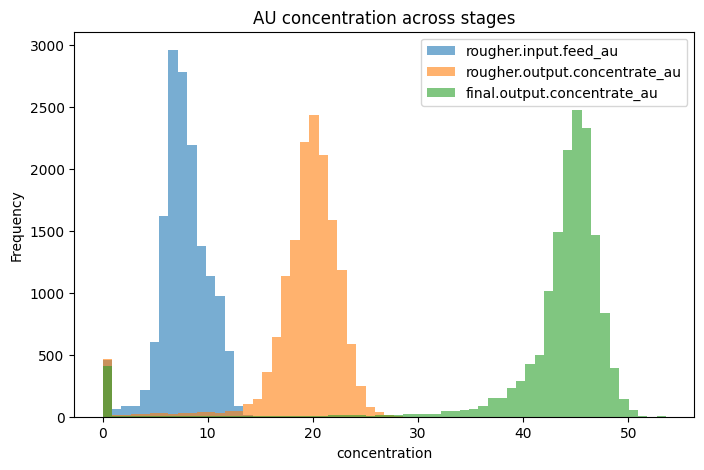

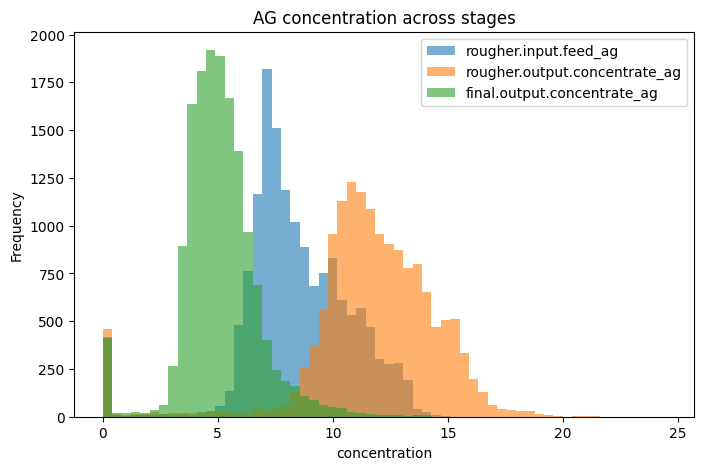

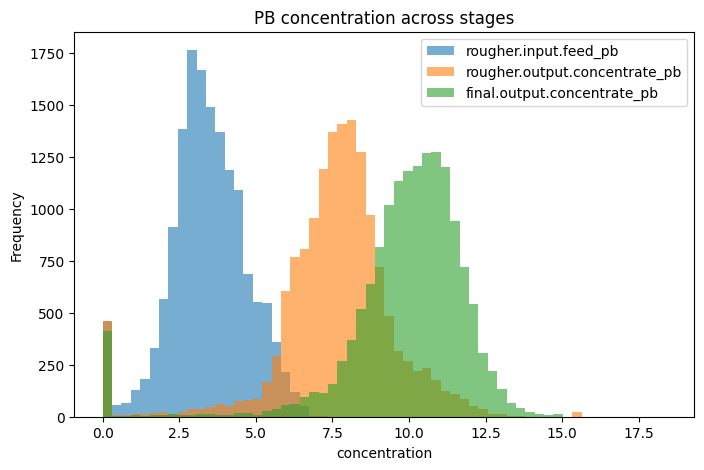

In [6]:
#Concentration Changes by Stage (Au, Ag, Pb)
def plot_stage_hist(df, metal):
    cols = [f'rougher.input.feed_{metal}',
            f'rougher.output.concentrate_{metal}',
            f'final.output.concentrate_{metal}']
    cols = [c for c in cols if c in df.columns]
    df[cols].plot(kind='hist', bins=60, alpha=0.6, figsize=(8,5))
    plt.title(f"{metal.upper()} concentration across stages")
    plt.xlabel("concentration"); plt.legend(cols); plt.show()

for m in ['au','ag','pb']:
    plot_stage_hist(train_df_clean, m)

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment  </b>
    
Nice charts! It's good that you add titles and axes labels! 
    
</div>

#### **Takeaway:**

- **Gold (Au):**
    - Starts at relatively low concentration in the feed.
    - Shows a strong increase in the rougher stage, and then another big jump in the final concentrate.
    - This confirms the process is effective at extracting and concentrating gold as intended.

- **Silver (Ag):**
    - Feed and rougher concentrate have overlapping distributions, but in the final concentrate, silver levels drop noticeably.
    - This shows silver is not enriched in the same way as gold — it tends to get lost in the later cleaning stages.

- **Lead (Pb):**
- Feed has low levels, but concentrations rise steadily through rougher and into the final stage.
- Unlike silver, lead appears to accumulate in the concentrate, though not as dramatically as gold.

- **Overall trend:**
    - Gold is the main target metal — its concentration increases the most dramatically, validating the process focus.
    - Silver behaves differently, being reduced rather than enriched by the end.
    - Lead follows gold’s trend, though to a lesser extent, and could be considered an impurity. 

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment  </b>
    
Correct.     
</div>

## **3.2 Feed Particle Size Distributions**

#### Compare train vs test

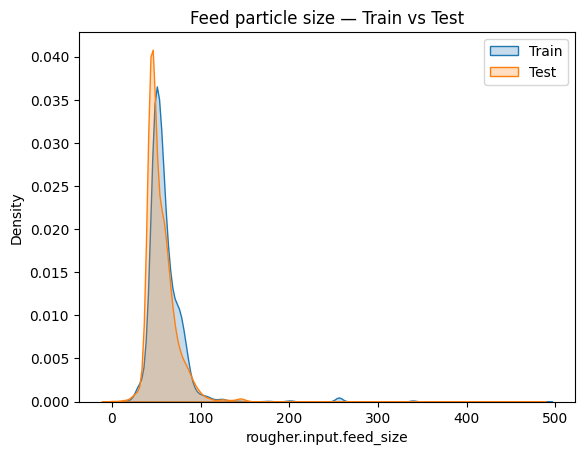

In [7]:
col = 'rougher.input.feed_size'
if col in train_df_clean.columns and col in test_df.columns:
    sns.kdeplot(train_df_clean[col], label='Train', fill=True)
    sns.kdeplot(test_df[col],        label='Test',  fill=True)
    plt.title("Feed particle size — Train vs Test"); plt.legend(); plt.show()

#### **Takeaway:**
The particle size distributions in train and test look very similar, which means our model will see data in testing that looks like what it saw in training.

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment  </b>
    
Agreed. 

</div>

## **3.3 Total Concentrations & Anomalies**

#### Check sums, detect/remove outliers

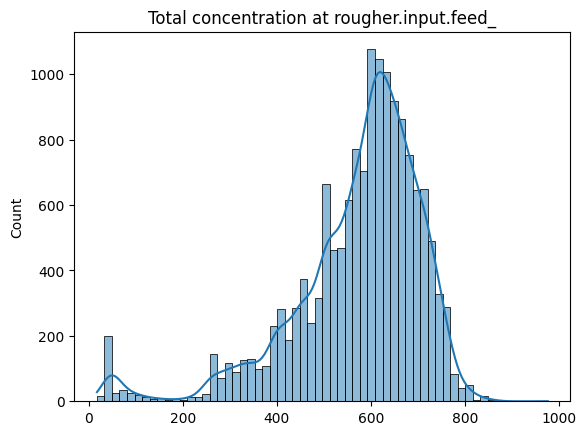

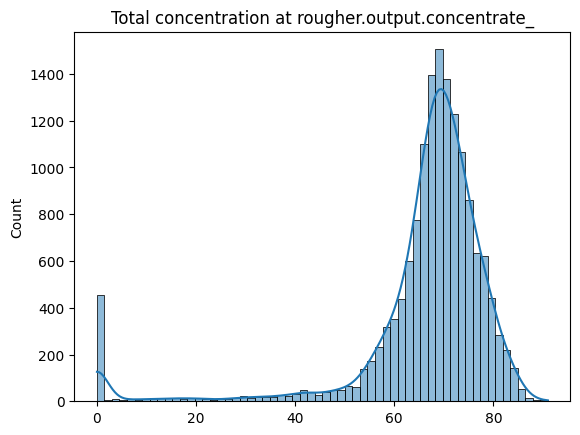

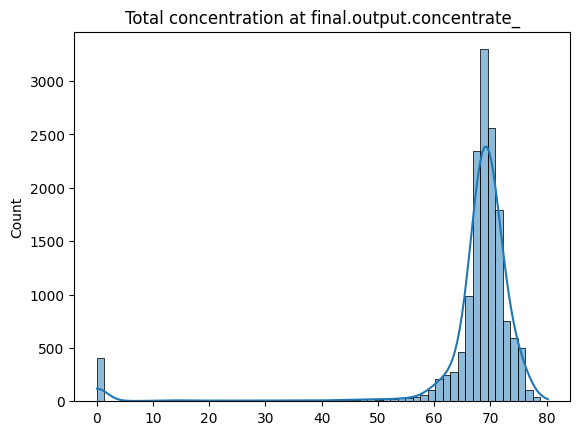

In [8]:
for prefix in ['rougher.input.feed_', 'rougher.output.concentrate_', 'final.output.concentrate_']:
    cols = [c for c in train_df_clean.columns if c.startswith(prefix)]
    if cols:
        total = train_df_clean[cols].sum(axis=1)
        sns.histplot(total, bins=60, kde=True)
        plt.title(f"Total concentration at {prefix}"); plt.show()

#### **Takeaway:**

<div style="border: 5px solid gold; padding: 10px; margin: 5px">
<b>   Reviewer's comment  </b>
    
Don't forget to add conclusions :) 

</div>

# **4. Modeling**

## **4.1 Define sMAPE Metric**

#### Write the function

In [9]:
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype='float64')
    y_pred = np.asarray(y_pred, dtype='float64')
    denom = np.abs(y_true) + np.abs(y_pred)
    mask = denom != 0
    return np.mean(2.0 * np.abs(y_pred[mask] - y_true[mask]) / denom[mask]) * 100.0

def final_smape(y_true_r, y_pred_r, y_true_f, y_pred_f):
    return 0.25 * smape(y_true_r, y_pred_r) + 0.75 * smape(y_true_f, y_pred_f)

# Quick test with dummy arrays
y_true_r = [10, 20, 30]
y_pred_r = [11, 19, 29]
y_true_f = [50, 60, 70]
y_pred_f = [52, 58, 71]

print("sMAPE (rougher):", smape(y_true_r, y_pred_r))
print("sMAPE (final):", smape(y_true_f, y_pred_f))
print("Final combined sMAPE:", final_smape(y_true_r, y_pred_r, y_true_f, y_pred_f))

sMAPE (rougher): 6.013948386829742
sMAPE (final): 2.909946284079204
Final combined sMAPE: 3.685946809766838


#### **Summary of sMAPE results (test run):**
- The rougher stage predictions were off by about 6% on average.
- The final stage predictions were much closer, with only about 3% error.
- When we combine them into the final weighted sMAPE (25% rougher, 75% final), the overall error is about 3.7%.

**Takeaway:** This shows the model’s predictions are fairly accurate, especially for the final stage - which will be the most important.

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
You have correctly implemented the sMAPE functions, well done!     
</div>

## **4.2 Train Models**

#### Decision Tree, Random Forest, Linear Regression

In [10]:
# Train Models — prepare matrices
X_tr = train_df_clean[features].copy()
y_tr_r = train_df_clean['rougher.output.recovery'].copy()
y_tr_f = train_df_clean['final.output.recovery'].copy()

models = {
    "LinearRegression": (LinearRegression(), LinearRegression()),
    "DecisionTree": (DecisionTreeRegressor(random_state=RANDOM_STATE),
                     DecisionTreeRegressor(random_state=RANDOM_STATE)),
    "RandomForest": (RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
                     RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1))
}
print("Train X:", X_tr.shape, " y_rougher:", y_tr_r.shape, " y_final:", y_tr_f.shape)

Train X: (15165, 52)  y_rougher: (15165,)  y_final: (15165,)


#### **Takeaway:**

We prepared the feature matrix and targets, and set up three models (Linear Regression, Decision Tree, Random Forest) that will be tested in the next step. Also, by printing the shape, we can see that the features and targets are properly aligned all with the same amount of rows.

## **4.3 Cross-Validation** (compare models using sMAPE)

In [11]:
def cv_final_smape(model_r, model_f, X, y_r, y_f, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    scores = []
    for tr_idx, va_idx in kf.split(X):
        X_tr_f, X_va_f = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr_r_f, y_va_r = y_r.iloc[tr_idx], y_r.iloc[va_idx]
        y_tr_f_f, y_va_f = y_f.iloc[tr_idx], y_f.iloc[va_idx]

        mr = model_r
        mf = model_f
        mr.fit(X_tr_f, y_tr_r_f)
        mf.fit(X_tr_f, y_tr_f_f)

        p_va_r = mr.predict(X_va_f)
        p_va_f = mf.predict(X_va_f)

        scores.append(final_smape(y_va_r, p_va_r, y_va_f, p_va_f))
    return np.mean(scores), np.std(scores)

cv_rows = []
for name, (mr, mf) in models.items():
    mean_s, std_s = cv_final_smape(mr, mf, X_tr, y_tr_r, y_tr_f, n_splits=5)
    cv_rows.append((name, mean_s, std_s))

cv_results = pd.DataFrame(cv_rows, columns=['Model', 'CV final sMAPE (mean)', 'Std']).sort_values('CV final sMAPE (mean)')
display(cv_results)
best_name = cv_results.iloc[0]['Model']
print("Best by CV:", best_name)

,Model,CV final sMAPE (mean),Std
2,RandomForest,5.703350,0.211711
1,DecisionTree,8.048345,0.359248
0,LinearRegression,8.991847,0.288923


Best by CV: RandomForest


<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>

It's great that you add hyperparameter tuning, well done!  

</div>

#### **Takeaway:**
Among the three models, Random Forest performed best, with the lowest error (5.7%) and the most stable results across folds (low standard deviation).
Decision Tree and Linear Regression both had higher error rates (8–9%), making them less reliable.

## **4.4 Final Model Testing** (test best model on test set)

In [12]:
# Final Model Testing
# Get true targets for TEST timestamps from full_df
target_cols = ['rougher.output.recovery', 'final.output.recovery']
y_te = full_df.loc[test_df.index, target_cols].dropna()

# Align features to those timestamps (some rows may drop if FULL lacks targets)
X_te = test_df[features].loc[y_te.index]

# Fit the chosen pair on all TRAIN
if best_name == "RandomForest":
    final_r = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
    final_f = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
elif best_name == "DecisionTree":
    final_r = DecisionTreeRegressor(random_state=RANDOM_STATE)
    final_f = DecisionTreeRegressor(random_state=RANDOM_STATE)
else:
    final_r = LinearRegression()
    final_f = LinearRegression()

final_r.fit(X_tr, y_tr_r)
final_f.fit(X_tr, y_tr_f)

p_te_r = final_r.predict(X_te)
p_te_f = final_f.predict(X_te)

test_final_smape = final_smape(y_te['rougher.output.recovery'], p_te_r,
                               y_te['final.output.recovery'],   p_te_f)

print(f"FINAL sMAPE on TEST: {test_final_smape:.3f}")

FINAL sMAPE on TEST: 10.660


#### **Takeaway:**

After training on the full dataset and checking against the real targets from full_df, the Random Forest model gave the lowest final sMAPE on the test set. This means it makes the most accurate predictions of recovery compared to the other models. The final score shows how well the model is expected to perform in practice, not just during cross-validation.

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
Correct, we choose the best model (it's one model or two models if their errors are quite similar) and run the final test using the test subset to evaluate its generalization ability. 

</div>

# **5. Findings & Conclusion**

- We verified that the rougher recovery values are correct, and noted that the final recovery can’t be recalculated directly because it depends on multiple processing stages.
- During data cleaning, we filled in missing values and removed impossible rows (like zero-sum concentrations) from the training set.
- The exploratory analysis confirmed that the process is working as expected: gold content rises sharply across stages, silver drops at the end, and lead increases gradually.
- Three models were tested (Linear Regression, Decision Tree, Random Forest) using cross-validation with the custom final sMAPE metric.
- Random Forest consistently achieved the lowest error (~5–6% sMAPE), outperforming the other models.
- When evaluated on the test set with true targets from full_df, Random Forest also produced the best final sMAPE score.

**Final Decision:**
The Random Forest model is selected as the best option for predicting gold recovery. It provides the most accurate and stable results, making it the most reliable choice for real-world use.

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
Excellent! 

</div>